# Computing features to train a MLP
This notebook will guide you through the use of the `keras` package to train a multilayer perceptron for handwritten digits classification. You are going to computing the histogram of gradients from the images in the `mnist` dataset (LeCun et al. 1998)

## Loading the packages

In [ ]:
%pip install tensorflow --upgrade
%pip install keras --upgrade

import numpy as np
from matplotlib import pyplot as pl

from skimage.feature import hog
from skimage import data, color, exposure

from keras.datasets import mnist
from keras.models import Sequential
from keras.layers.core import Dense, Dropout
from tensorflow.keras.optimizers import RMSprop
from keras.utils import np_utils
from sklearn import metrics as me

%matplotlib inline

Load the `mnist` dataset and normalize in the range [0, 1]

In [ ]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

n_train, height, width = X_train.shape
n_test, _, _ = X_test.shape

X_train = X_train.reshape(n_train, height, width, 1).astype('float32')
X_test = X_test.reshape(n_test, height, width, 1).astype('float32')

X_train /= 255.0
X_test /= 255.0

n_classes = 10

print(n_train, 'train samples')
print(n_test, 'test samples')

# convert class vectors to binary class matrices
Y_train = np_utils.to_categorical(y_train, n_classes)
Y_test = np_utils.to_categorical(y_test, n_classes)

60000 train samples
10000 test samples


### An example of how to compute the histogram of gradients
Let's compute the HOG for one image in the test dataset

In [ ]:
n_orientations = 8
pix_p_cell = 4
hog_size = int(height * width * n_orientations / (pix_p_cell * pix_p_cell))

In [ ]:
fd, hog_image = hog(X_test[0,:,:,0], orientations=n_orientations, pixels_per_cell=(pix_p_cell, pix_p_cell), cells_per_block=(1, 1), visualize=True)
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 0.02))

Show the image and the corresponding gradients

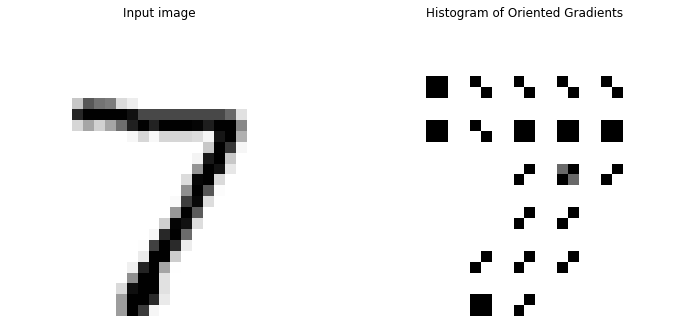

In [ ]:
fig, (ax1, ax2) = pl.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=True)
ax1.axis('off')
ax1.imshow(X_test[0,:,:,0], cmap=pl.get_cmap('Greys'), interpolation='nearest')
ax1.set_title('Input image')
ax1.set_adjustable('box')

ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=pl.get_cmap('Greys'), interpolation='nearest')
ax2.set_title('Histogram of Oriented Gradients')
ax1.set_adjustable('box')

Compute the HOGs for the train and test datasets

> Indented block



In [ ]:
X_train_hog = np.zeros((X_train.shape[0], hog_size))
X_test_hog = np.zeros((X_test.shape[0], hog_size))

for i in np.arange(X_train_hog.shape[0]):
    X_train_hog[i,:] = hog(X_train[i,:,:,0], orientations=n_orientations, pixels_per_cell=(pix_p_cell, pix_p_cell), cells_per_block=(1, 1), visualize=False)
print('X_train done')

for i in np.arange(X_test_hog.shape[0]):
    X_test_hog[i,:] = hog(X_test[i,:,:,0], orientations=n_orientations, pixels_per_cell=(pix_p_cell, pix_p_cell), cells_per_block=(1, 1), visualize=False)
print('X_test done')

X_train done
X_test done


Create the MLP

In [ ]:
model = Sequential()
model.add(Dense(200, input_shape=(hog_size,), activation='relu'))
#model.add(Dropout(0.5))
model.add(Dense(n_classes, activation='softmax'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 200)               78600     
_________________________________________________________________
dense_4 (Dense)              (None, 10)                2010      
Total params: 80,610
Trainable params: 80,610
Non-trainable params: 0
_________________________________________________________________


Define some constants and train the MLP

In [ ]:
batch_size = 128
n_epoch = 10

model.compile(loss='categorical_crossentropy', optimizer=RMSprop(), metrics=['accuracy'])
history = model.fit(X_train_hog, Y_train,
                    batch_size=batch_size, epochs=n_epoch,
                    verbose=1, validation_data=(X_test_hog, Y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 2s 37us/step - loss: 0.2236 - acc: 0.9470 - val_loss: 0.0915 - val_acc: 0.9714
Epoch 2/10
60000/60000 [==============================] - 2s 35us/step - loss: 0.0890 - acc: 0.9714 - val_loss: 0.0772 - val_acc: 0.9752
Epoch 3/10
60000/60000 [==============================] - 2s 36us/step - loss: 0.0739 - acc: 0.9760 - val_loss: 0.0714 - val_acc: 0.9765
Epoch 4/10
60000/60000 [==============================] - 2s 35us/step - loss: 0.0632 - acc: 0.9802 - val_loss: 0.0705 - val_acc: 0.9770
Epoch 5/10
60000/60000 [==============================] - 2s 34us/step - loss: 0.0555 - acc: 0.9821 - val_loss: 0.0689 - val_acc: 0.9780
Epoch 6/10
60000/60000 [==============================] - 2s 35us/step - loss: 0.0487 - acc: 0.9846 - val_loss: 0.0636 - val_acc: 0.9802
Epoch 7/10
60000/60000 [==============================] - 2s 35us/step - loss: 0.0429 - acc: 0.9866 - val_loss: 0.0624 - val_acc

Show the performance of the model

Test score: 0.06650333051643101
Test accuracy: 0.9801


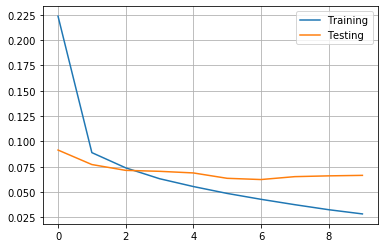

In [ ]:
pl.plot(history.history['loss'], label='Training')
pl.plot(history.history['val_loss'], label='Testing')
pl.legend()
pl.grid()

score = model.evaluate(X_test_hog, Y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

Confusion matrix

In [ ]:
pred = model.predict(X_test_hog)
pred = np.argmax(pred, axis=-1)
me.confusion_matrix(y_test, pred)

array([[ 965,    0,    1,    0,    0,    2,    6,    3,    2,    1],
       [   2, 1123,    1,    3,    0,    1,    2,    1,    2,    0],
       [   1,    3, 1018,    0,    2,    0,    1,    3,    4,    0],
       [   0,    0,    3,  999,    0,    3,    0,    2,    3,    0],
       [   0,    1,    3,    0,  972,    0,    1,    0,    3,    2],
       [   1,    0,    0,   22,    0,  862,    5,    0,    2,    0],
       [   3,    2,    1,    0,    3,    2,  946,    0,    1,    0],
       [   1,    4,    7,    3,    4,    0,    0, 1002,    4,    3],
       [   3,    0,    2,   11,    1,    1,    1,    5,  946,    4],
       [   1,    2,    1,    9,   11,    4,    0,    6,    7,  968]])